In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40 kB 1.7 MB/s eta 0:00:011
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-py3-none-any.whl size=30114 sha256=8add6b6b4598d4c300f4814767ee1440b896ccacbd5ae05a428af27aa710a1a0
  Stored in directory: /home/nobu_yamaguchi/.cache/pip/wheels/6c/c9/9c/363182ea34a736dae336eeaf0dd4a7eec3c6a5afe32373e1fe
  Created wheel for py-params: filename=py_params-0.9.7-py3-none-any.whl size=7302 sha256=8ac0dcbc968ce8599110cba6d6bb23899f4465fb7eea4584186b35556c449a0a
  Stored in directory: /home/nobu_yamaguchi/.cache/pip/wheels/47/3d/2d/bbffcfd6b9f4b8b5cbf07e7520ac2676192fe9431240c13ee8
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=db82dd4d94cafc56d4ee6e075c4dc30fc1c29e662d0b70567d39fb5248e18166
  Stored in directory: /home/nobu_yamaguchi/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
Successfully built bert-for-tf2 py-params params-flow
You should consider upgrading via 

In [4]:
!pip install tensorflow_hub

     |████████████████████████████████| 101 kB 2.7 MB/s ta 0:00:011
You should consider upgrading via the '/home/nobu_yamaguchi/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf

import tensorflow_hub as hub
import numpy as up
import pandas as pd
from tensorflow.keras import layers
import bert

In [2]:
import numpy as np
import pandas as pd
import pickle as cPickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


In [10]:
patent_abstract = pd.read_csv('patent_abstract_5000.csv')
patent_abstract.shape

(5000, 31)

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

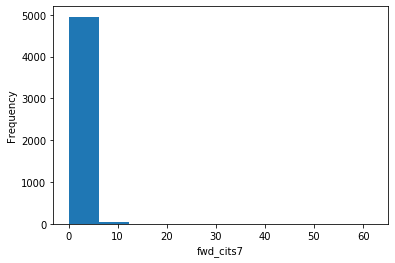

In [12]:
plt.hist(patent_abstract['fwd_cits7'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('fwd_cits7');

In [16]:
conditions = [

    (patent_abstract['fwd_cits7'] < 1),
    (patent_abstract['fwd_cits7'] >= 1)
]

choices = ['0', '1']

patent_abstract['fwd_cits7_rank'] = np.select(condlist=conditions, choicelist=choices)

In [17]:
df = patent_abstract[['text', 'fwd_cits7_rank']]

In [18]:
patent_abstract['fwd_cits7_rank'].value_counts()

0    3408
1    1592
Name: fwd_cits7_rank, dtype: int64

In [19]:
df.shape

(5000, 2)

In [20]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [21]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [22]:
abstracts = []
sentences = list(df['text'])
for sen in sentences:
    abstracts.append(preprocess_text(sen))

In [23]:
print(df.columns.values)

['text' 'fwd_cits7_rank']


In [25]:
df.fwd_cits7_rank.unique()

array(['0', '1'], dtype=object)

In [26]:
y = df.fwd_cits7_rank

In [27]:
y[10]

'1'

In [28]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [29]:
def tokenize_abstracts(text_abstracts):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_abstracts))

In [30]:
tokenized_abstracts = [tokenize_abstracts(abstract) for abstract in abstracts]

Prerparing Data For Training

In [31]:
abstracts_with_len = [[abstract, y[i], len(abstract)]
                 for i, abstract in enumerate(tokenized_abstracts)]

In [32]:
np.random.shuffle(abstracts_with_len)

In [33]:
abstracts_with_len.sort(key=lambda x: x[2])

In [34]:
sorted_abstracts_labels = [(abstract_lab[0], abstract_lab[1]) for abstract_lab in abstracts_with_len]

In [35]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_abstracts_labels, output_types=(tf.int32, tf.int32))

In [36]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [37]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 23), dtype=int32, numpy=
 array([[ 1037,  8822,  2291,  2005,  2019,  2948,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 4725,  2005,  8225,  1996,  2206,  7328,  2024, 21362,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 1996, 11028, 14623,  2000,  2019, 14794,  9179, 17564,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 1996, 11028, 14623,  2000, 25416, 22648,  7062, 14692,  8670,
         18142,  8962,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 4725,  1998,  9265,  3141,  2000, 14126,  6074,  2000, 13656,
          8153,  2024,  2649,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
      

In [38]:
TOTAL_BATCHES = np.math.ceil(len(sorted_abstracts_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 20
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [39]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [45]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.3

NB_EPOCHS = 5

In [46]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [47]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["acc"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [48]:
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/5
150/150 [==============================] - 27s 178ms/step - loss: 0.6326 - acc: 0.6809
Epoch 2/5
150/150 [==============================] - 26s 174ms/step - loss: 0.5907 - acc: 0.6876
Epoch 3/5
150/150 [==============================] - 26s 173ms/step - loss: 0.3540 - acc: 0.8474
Epoch 4/5
150/150 [==============================] - 26s 173ms/step - loss: 0.0585 - acc: 0.9879
Epoch 5/5
150/150 [==============================] - 26s 171ms/step - loss: 0.0103 - acc: 0.9987


In [49]:
results = text_model.evaluate(test_data)
print(results)

      7/Unknown - 0s 31ms/step - loss: 1.4242 - acc: 0.5402[1.4242296133722578, 0.5401786]
